# Information extraction Task

In [93]:
#%pip install spacy
#!python -m spacy download de_core_news_md

In [94]:
# Import the necessary libraries
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv("ds_ner_test_case.csv")
df.head()

# Load the German spaCy model
nlp = spacy.load("de_core_news_md")


In [95]:
# Show all columns
print("Columns:", df.columns.tolist())

# Missing values in important fields
df[["description", "Brand", "Speicherkapazität", "Farbe"]].isnull().mean().round(2) * 100


Columns: ['description', 'highlights', 'headline', 'Brand', 'Speicherkapazität', 'Farbe', 'productId']


description           0.0
Brand                 0.0
Speicherkapazität    43.0
Farbe                37.0
dtype: float64

In [96]:
# Check the data types of the columns
df.dtypes

description           object
highlights            object
headline              object
Brand                 object
Speicherkapazität     object
Farbe                 object
productId            float64
dtype: object

<Axes: title={'center': 'Top 10 Brands'}, xlabel='Brand'>

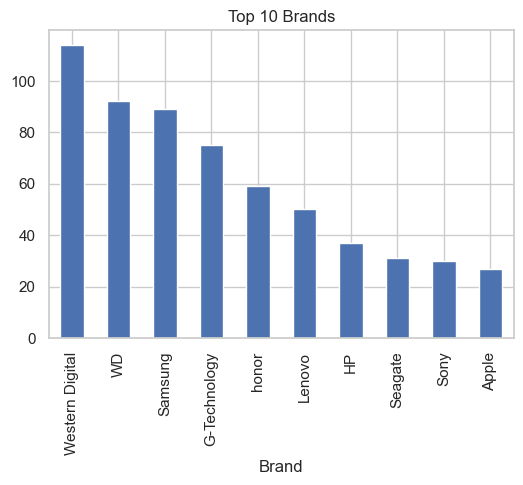

In [97]:
df["Brand"].value_counts().head(10).plot(kind="bar", title="Top 10 Brands", figsize=(6, 4))

<Axes: title={'center': 'Top Storage Values'}, xlabel='Speicherkapazität'>

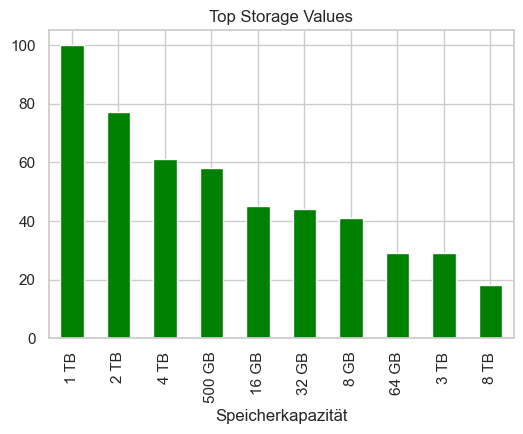

In [98]:
df["Speicherkapazität"].value_counts().head(10).plot(kind="bar", title="Top Storage Values", color='green', figsize=(6, 4))

<Axes: title={'center': 'Top Colors'}, xlabel='Farbe'>

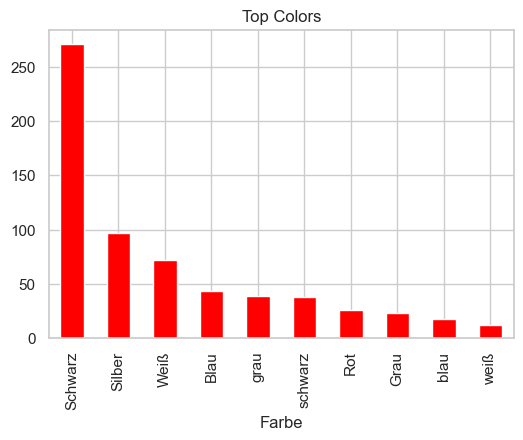

In [99]:
df["Farbe"].value_counts().head(10).plot(kind="bar", title="Top Colors", color='red', figsize=(6, 4))

In [100]:
# Extract all entities using spaCy (if needed to analyse the full data)
def extract_entities_spacy(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [101]:
df.head(5)

,description,highlights,headline,Brand,Speicherkapazität,Farbe,productId
0,"Das G56JR steckt voller Komponenten, deren Per...",<b> Intel Core i7-4700HQ der vierten Generati...,ASUS G56JR-CN169H,Asus,NaN,Schwarz,52.0
1,Das IdeaPad Yoga 13 ist eines der ersten Ultra...,<b> Ultrabook mit klappbarem Multitouch-Displ...,LENOVO IdeaPad Yoga2 Pro 13 Orange,Lenovo,NaN,Orange,87.0
2,Das Lenovo Flex2-15 ist ein schlankes und leic...,"<b> 15,6""-«Dual-Mode»-Notebook, schwarz</b> <...",LENOVO IdeaPad Flex2-15 schwarz,Lenovo,NaN,Schwarz,100.0
3,Das Lenovo Flex2-15 ist ein schlankes und leic...,"<b> Erschwingliches 15,6""-Dual-Mode-Notebook,...",LENOVO IdeaPad Flex2-15 schwarz,Lenovo,NaN,Schwarz,101.0
4,Das IdeaPad Yoga 13 ist eines der ersten Ultra...,<b> Ultrabook mit klappbarem Multitouch-Displ...,LENOVO IdeaPad Yoga2 Pro 13 Orange,Lenovo,NaN,Orange,107.0


### final solution to extract the dataset to train the model

In [102]:
import pandas as pd
import re
import spacy

# Load German model if needed later (not used directly here but keep if you want NER)
nlp = spacy.load("de_core_news_md")

# Load your data
df = pd.read_csv("ds_ner_test_case.csv")

# --- Storage extraction ---

def extract_storage(text):
    if not isinstance(text, str):
        return None
    # Find all GB/TB-like values
    matches = re.findall(r"\b\d+\s?(GB|TB)\b", text, re.IGNORECASE)
    for match in matches:
        # Search for the exact match in text to get context
        context_match = re.search(r"(\d+\s?(GB|TB))", text, re.IGNORECASE)
        if context_match:
            span = context_match.span()
            # Get context around the matched storage size
            context = text[max(0, span[0]-15):span[1]+15].lower()
            # Exclude if context indicates RAM or memory
            if not any(kw in context for kw in ["ram", "arbeitsspeicher", "ddr"]):
                return context_match.group(1)
    return None

def extract_storage_from_priority(row):
    for field in ["headline", "highlights", "description"]:
        storage = extract_storage(row.get(field, ""))
        if storage:
            return storage
    return None

df["storage"] = df.apply(extract_storage_from_priority, axis=1)

# --- Color extraction ---

color_list = [
    "schwarz", "weiß", "weiss", "rot", "blau", "gelb", "grün", "gruen", "grau", "braun",
    "lila", "türkis", "tuerkis", "koralle", "silber", "anthrazit", "rauchgrau",
    "aluminium", "hellblau", "dunkelblau", "violett", "neongelb", "wildkirsche",
    "black", "white", "red", "blue", "green", "yellow", "gray", "grey", "silver",
    "gold", "pink", "purple", "orange", "brown", "beige", "turquoise", "navy",
    "ruby", "graphite",
    "silber-grau", "silber-schwarz", "weiß-rot", "schwarz-neongelb", "silber/weiß"
]

# Compile regex pattern once
pattern = re.compile(r"\b(" + "|".join(map(re.escape, color_list)) + r")\b", re.IGNORECASE)

def extract_color(text):
    if not isinstance(text, str):
        return None
    match = pattern.search(text.lower())
    if match:
        return match.group(1)
    return None

def extract_color_from_priority(row):
    for field in ["headline", "highlights", "description"]:
        color = extract_color(row.get(field, ""))
        if color:
            return color
    return None

df["color_extracted"] = df.apply(extract_color_from_priority, axis=1)

def extract_brand_from_headline(headline):
    if isinstance(headline, str) and headline.strip():
        return headline.strip().split()[0]
    return None

df["brand_extracted"] = df["headline"].apply(extract_brand_from_headline)


# --- Convert storage values to GB ---
# Function to convert storage values to GB
def convert_storage_to_gb(storage_str):
    """
    Extracts all storage values (GB or TB) from a string and returns the **total** in GB.
    """
    if pd.isnull(storage_str):
        return None

    # Find all matches like "512 GB", "1 TB", "256GB", etc.
    matches = re.findall(r'(\d+(?:[.,]\d+)?)\s*(TB|GB)', storage_str.upper())
    
    total_gb = 0
    for value, unit in matches:
        value = float(value.replace(',', '.'))  # Handle comma decimal
        if unit == 'TB':
            value *= 1024
        total_gb += value

    return int(total_gb) if total_gb else None


# Define color mapping dictionary (expand as needed)
color_mapping = {
    "black": "Schwarz",
    "schwarz": "Schwarz",
    "white": "Weiß",
    "weiß": "Weiß",
    "blue": "Blau",
    "Blue": "Blau",
    "blau": "Blau",
    "red": "Rot",
    "rot": "Rot",
    "green": "Grün",
    "grün": "Grün",
    "silver": "Silber",
    "silber": "Silber",
    "gray": "Grau",
    "grau": "Grau",
    "gold": "Gold",
    "pink": "Pink",
    "lila": "Lila",
    "purple": "Lila",
    "orange": "Orange",
    "brown": "Braun",
    "braun": "Braun"
}

# Function to standardize color values
def standardize_color(value):
    if pd.isna(value):
        return None
    value_lower = str(value).strip().lower()
    return color_mapping.get(value_lower, value)

# Standardize color_extracted and farbe (original)
df["color_extracted_std"] = df["color_extracted"].apply(standardize_color)

# --- Fill missing values in your existing columns with extracted data ---
df["farbe_filled"] = df["Farbe"].combine_first(df["color_extracted_std"])
df["storage_filled"] = df["Speicherkapazität"].combine_first(df["storage"])


# Apply function to your DataFrame
df["storage_gb"] = df["storage_filled"].apply(convert_storage_to_gb)


cleaned_df = df[["brand_extracted", "farbe_filled", "storage_gb"]]
# Save the result to a new CSV file
df.to_csv("ds_ner_test_case_cleaned_combined.csv", index=False)

df[["headline", "brand_extracted", "farbe_filled", "storage_gb"]].to_csv("enriched_products.csv", index=False)


In [103]:
print("input colors:", df["Farbe"].notnull().sum())
print("input storage:", df["Speicherkapazität"].notnull().sum())
print("Filled colors:", df["farbe_filled"].notnull().sum())
print("Filled storage:", df["storage_gb"].notnull().sum())
print(df[["headline", "brand_extracted", "color_extracted", "storage_gb"]].sample(5))


input colors: 725
input storage: 664
Filled colors: 907
Filled storage: 753
                                              headline brand_extracted  \
866               honor 9 Lite LTE-Dual-SIM Smartphone           honor   
87             chiliGreen externe Festplatte 2,5" 1 TB      chiliGreen   
960  Manhattan Power Delivery USB-Netzteil – 60 W L...       Manhattan   
162  Acer Aspire E5-551G-F11E Notebook 39.6 cm (15....            Acer   
84             chiliGreen externe Festplatte 2,5" 1 TB      chiliGreen   

    color_extracted  storage_gb  
866            None        32.0  
87             None      1024.0  
960            weiß         NaN  
162         schwarz         NaN  
84             None      1024.0  


In [104]:
# Check the data types of the columns
df.dtypes

description             object
highlights              object
headline                object
Brand                   object
Speicherkapazität       object
Farbe                   object
productId              float64
storage                 object
color_extracted         object
brand_extracted         object
color_extracted_std     object
farbe_filled            object
storage_filled          object
storage_gb             float64
dtype: object

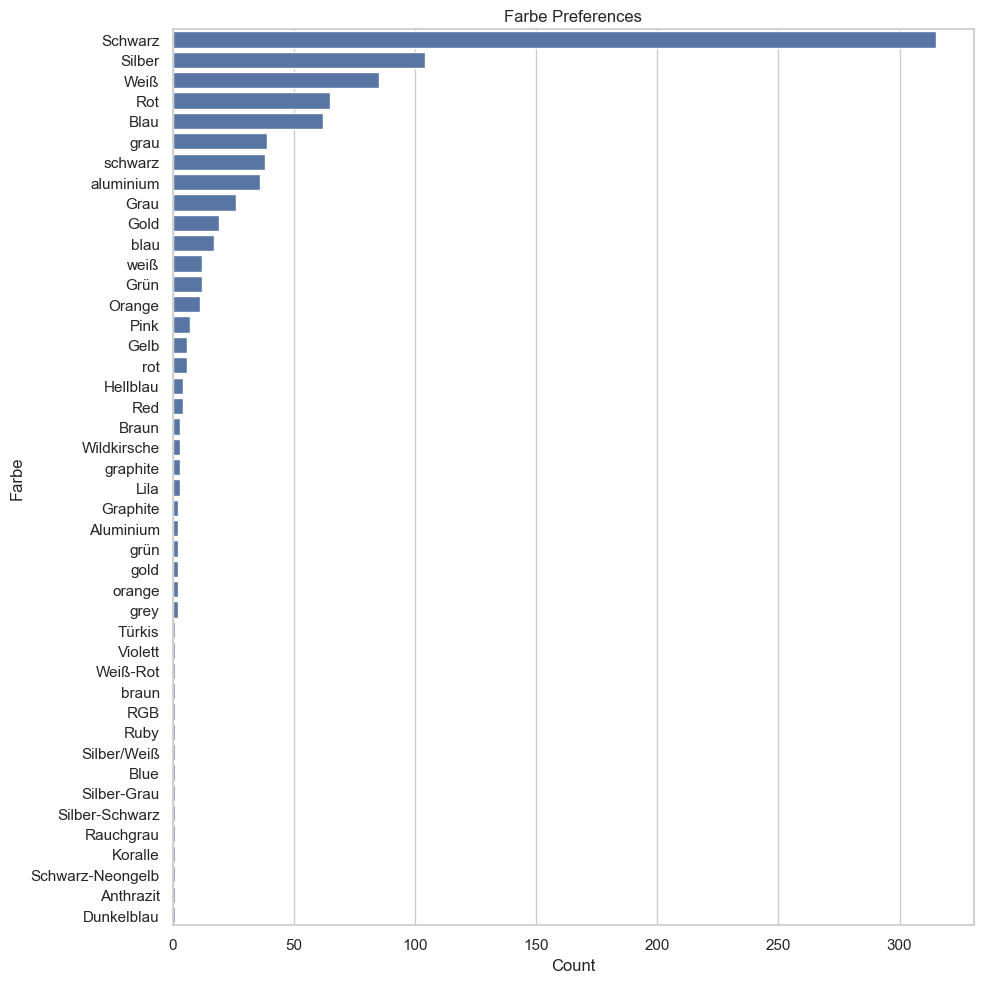

In [105]:
# Set plot style
sns.set(style="whitegrid")

# -----  Color Distribution -----
plt.figure(figsize=(10, 10))
sns.countplot(data=df, y="farbe_filled", order=df["farbe_filled"].value_counts().index)
plt.title("Farbe Preferences")
plt.xlabel("Count")
plt.ylabel("Farbe")
plt.tight_layout()
plt.show()


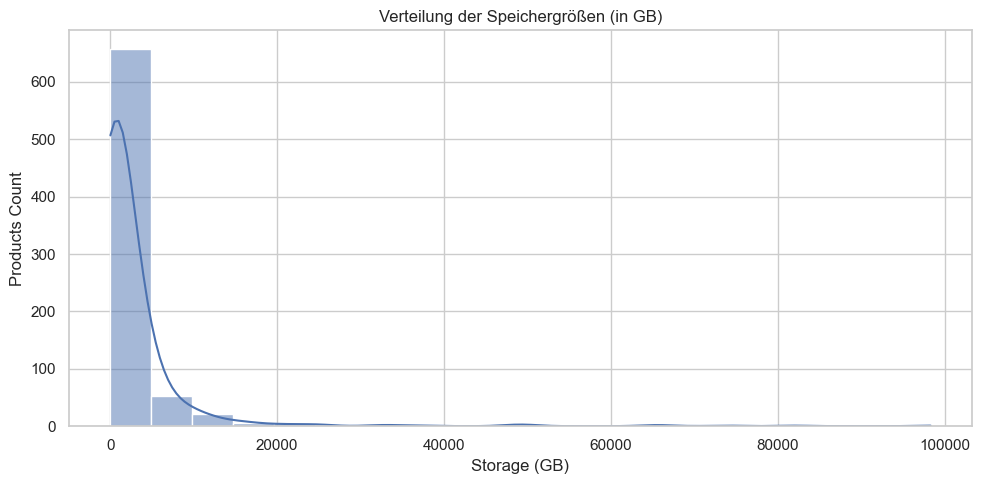

In [106]:
# ----- Storage Distribution (Histogram) -----
plt.figure(figsize=(10, 5))
sns.histplot(df["storage_gb"].dropna(), bins=20, kde=True)
plt.title("Verteilung der Speichergrößen (in GB)")
plt.xlabel("Storage (GB)")
plt.ylabel("Products Count")
plt.tight_layout()
plt.show()


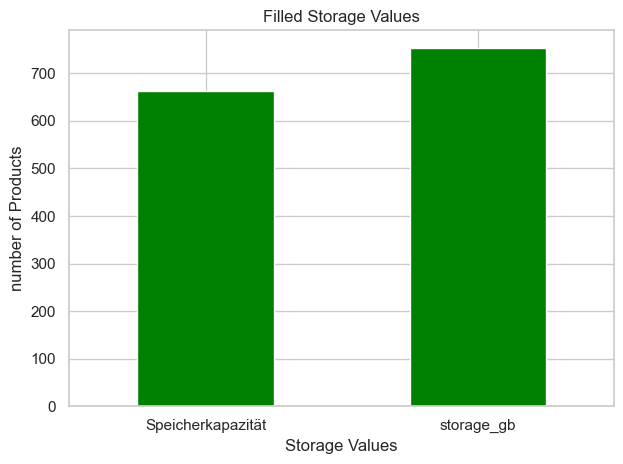

In [107]:
filled_counts = df[["Speicherkapazität", "storage_gb"]].notna().sum()
filled_counts.plot(kind='bar', color='green')
plt.title("Filled Storage Values")
plt.xlabel("Storage Values")
plt.ylabel("number of Products")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

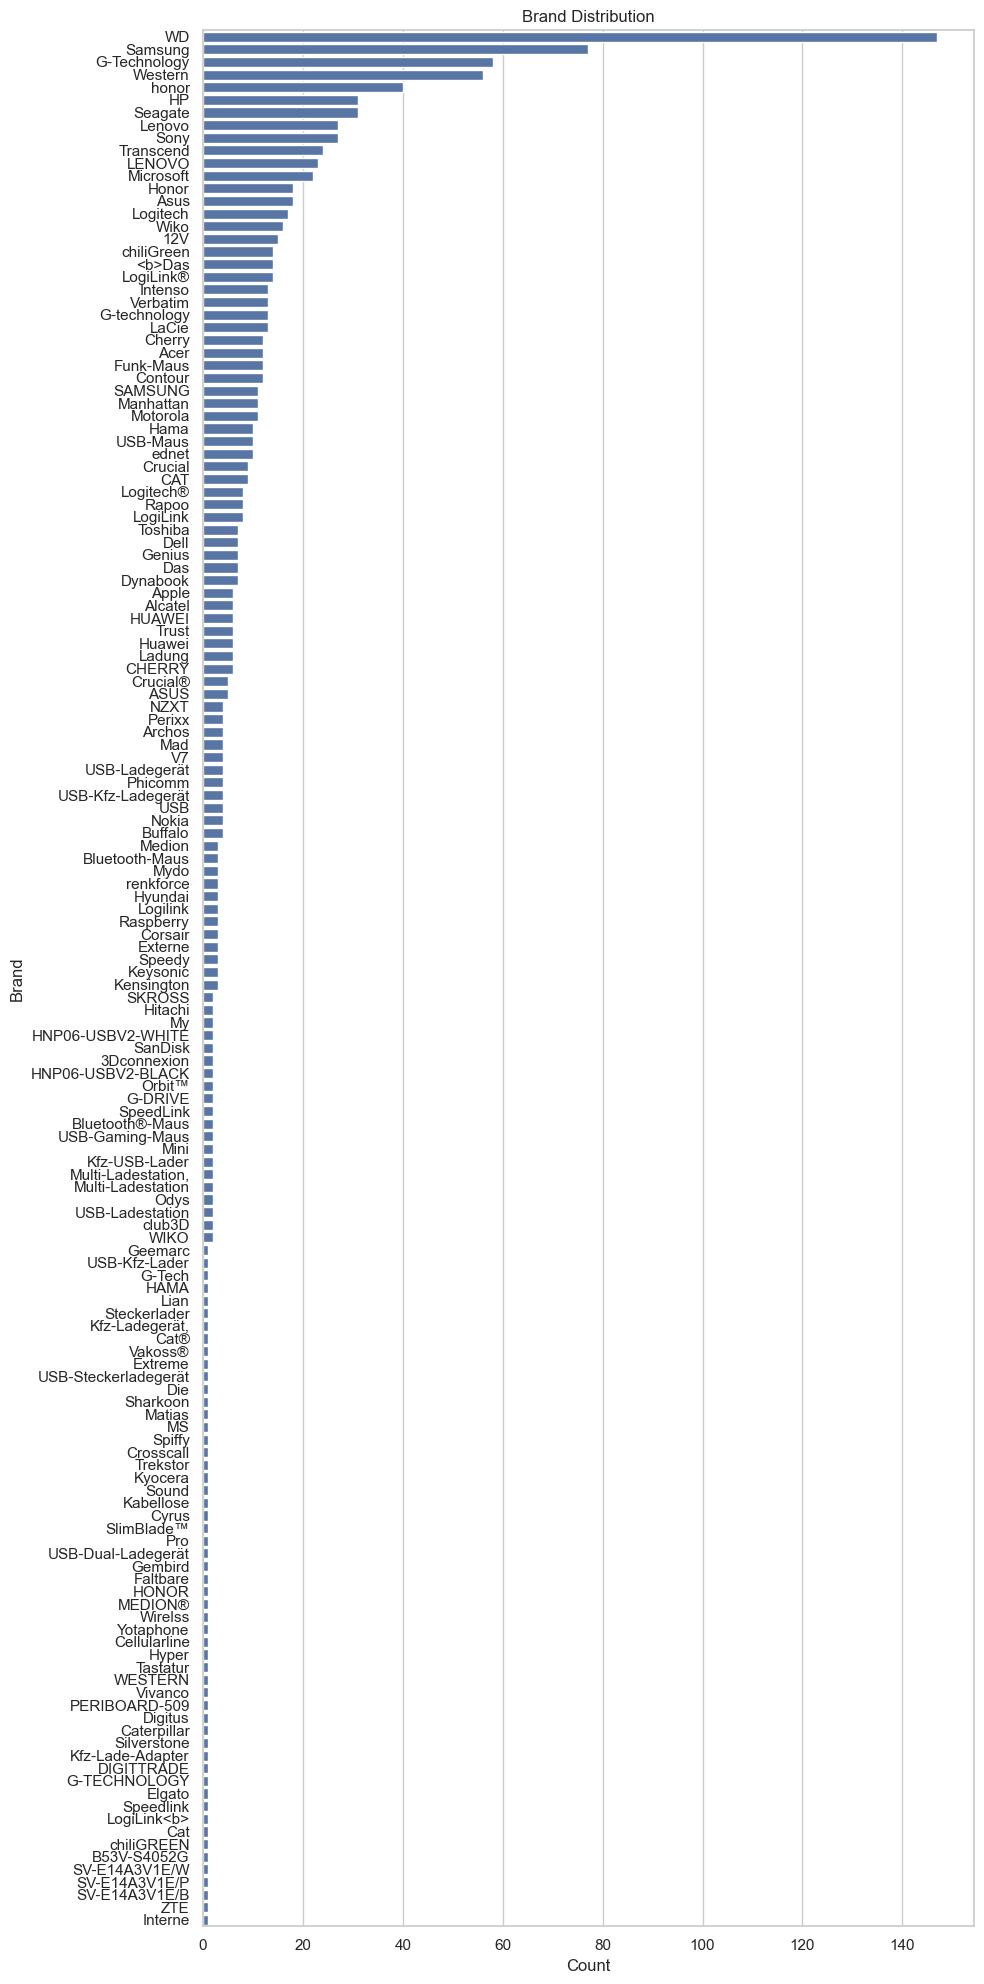

In [108]:
# ----- Brand Distribution -----
plt.figure(figsize=(10, 20))
sns.countplot(data=df, y="brand_extracted", order=df["brand_extracted"].value_counts().index)
plt.title("Brand Distribution")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

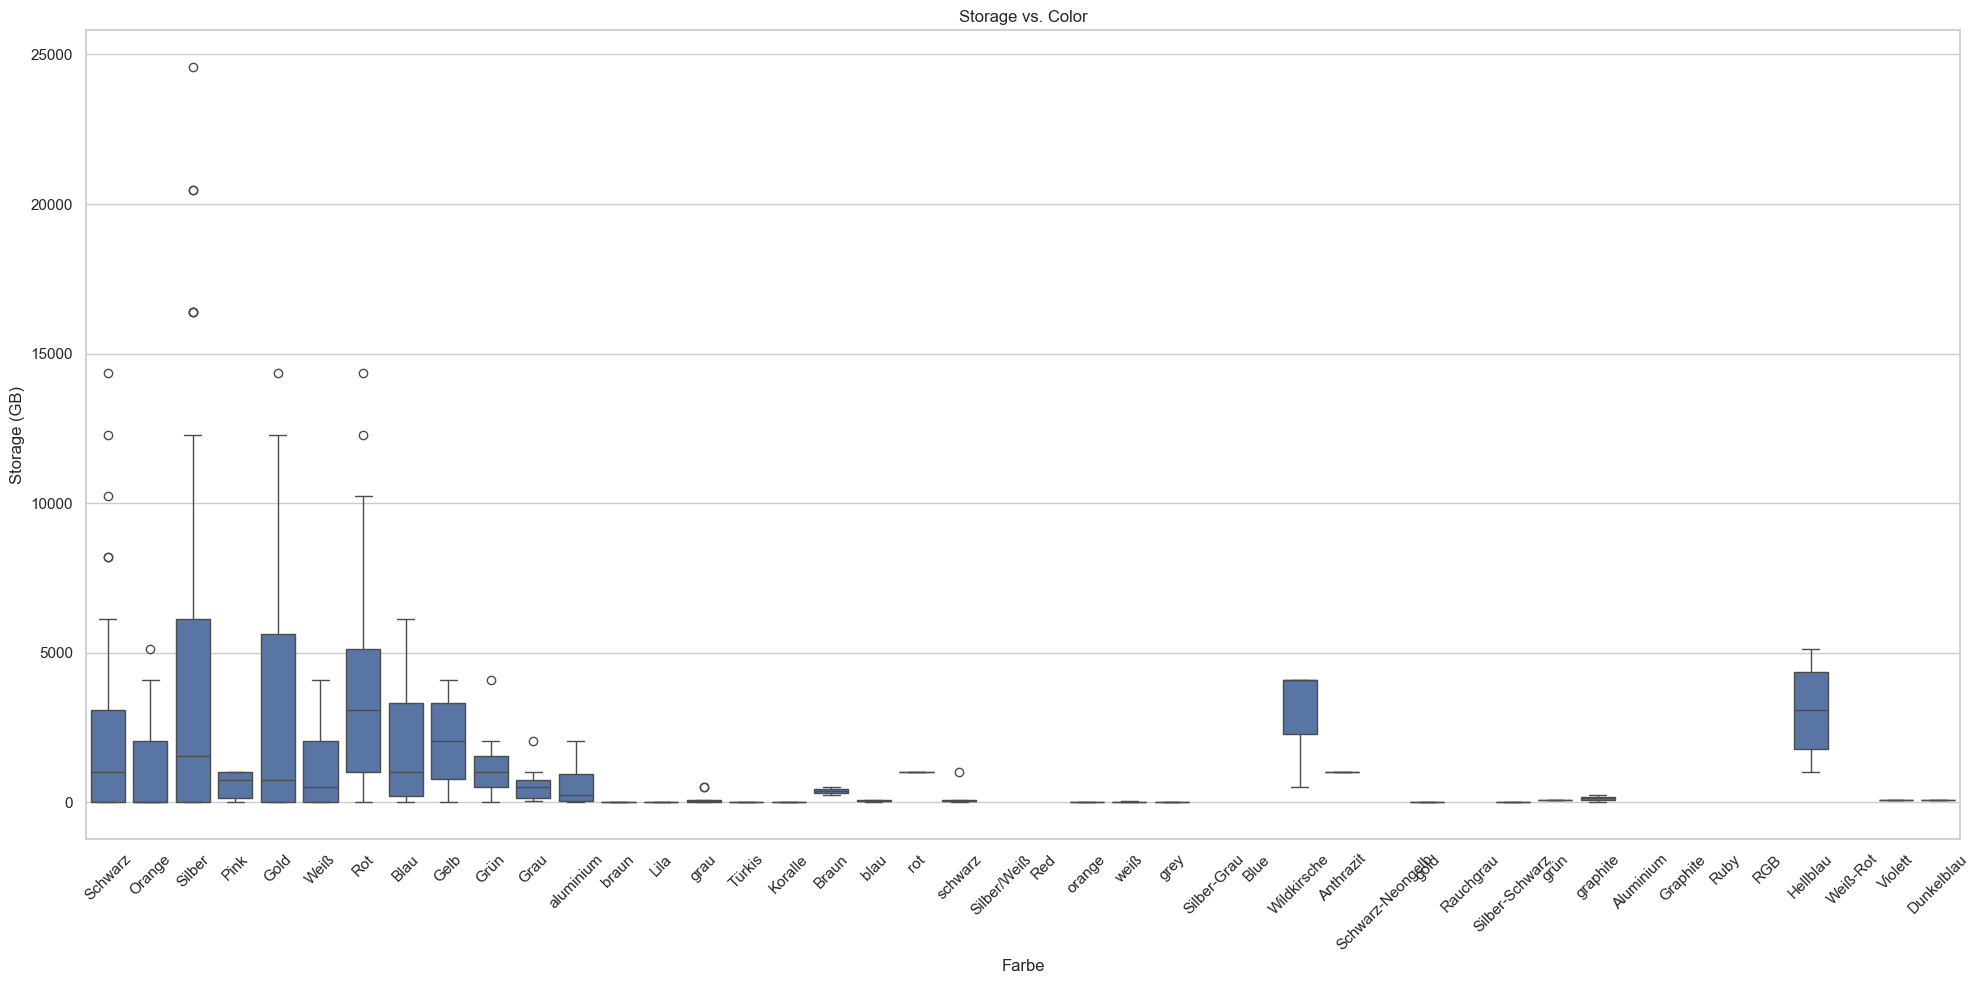

In [109]:
# ----- Storage vs. Color -----
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, x="farbe_filled", y="storage_gb")
plt.title("Storage vs. Color")
plt.xlabel("Farbe")
plt.ylabel("Storage (GB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [110]:
summary = {
    "Total Rows": len(df),
    "Colors": df["farbe_filled"].notna().sum(),
    "Brand": df["Brand"].notna().sum(),
    "Storage": df["storage_gb"].notna().sum()
}
print(pd.Series(summary))


Total Rows    1155
Colors         907
Brand         1155
Storage        753
dtype: int64


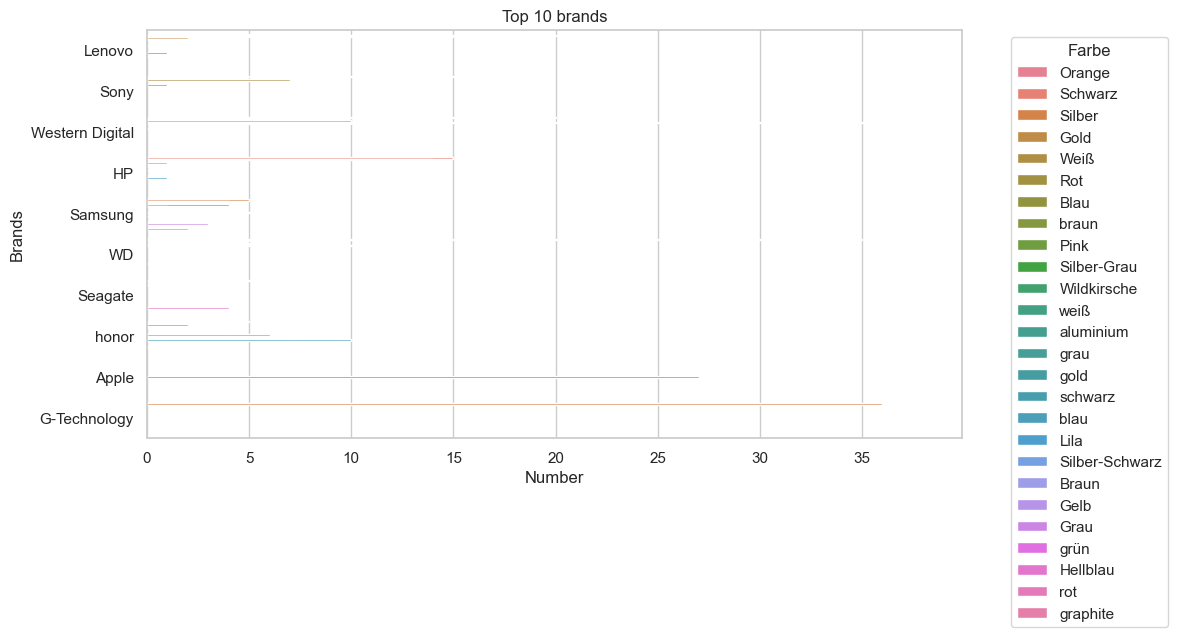

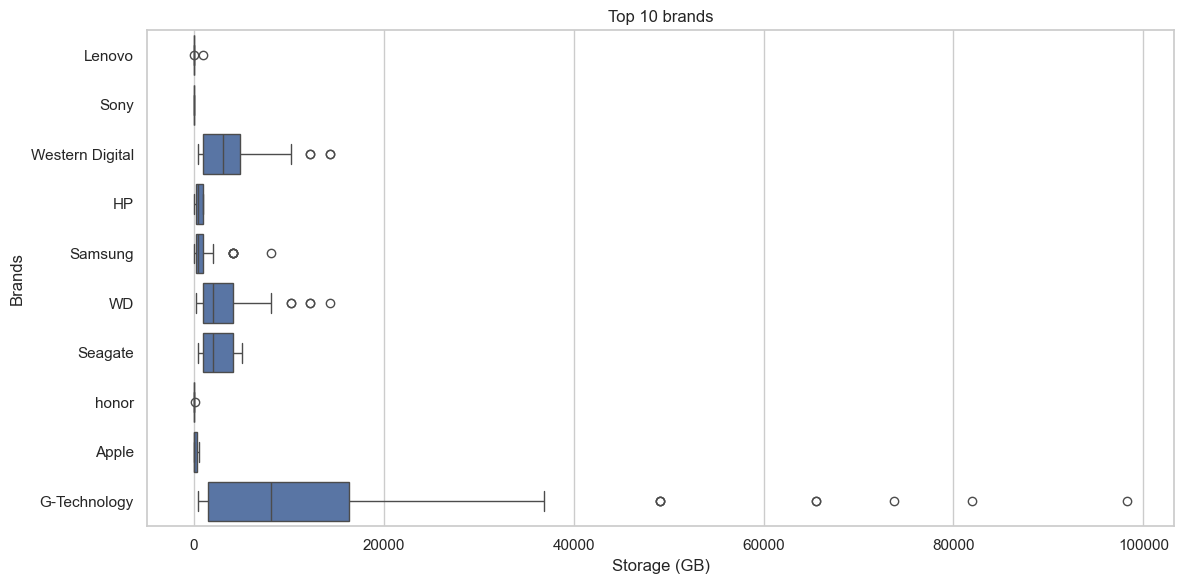

In [111]:
# Top 10 brands by count
top_brands = df["Brand"].value_counts().head(10).index

# Color by brand
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df["Brand"].isin(top_brands)], 
              y="Brand", hue="farbe_filled")
plt.title("Top 10 brands")
plt.xlabel("Number")
plt.ylabel("Brands")
plt.legend(title="Farbe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Storage by brand (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df["Brand"].isin(top_brands)], 
            y="Brand", x="storage_gb")
plt.title("Top 10 brands")
plt.xlabel("Storage (GB)")
plt.ylabel("Brands")
plt.tight_layout()
plt.show()


In [112]:
import unittest

# Define test cases directly in the notebook
class TestProductDetailExtraction(unittest.TestCase):

    def test_extract_storage(self):
        self.assertEqual(extract_storage("Smartphone mit 128 GB Speicher"), "128 GB")
        self.assertEqual(extract_storage("Laptop mit 1 TB Festplatte"), "1 TB")
        self.assertIsNone(extract_storage("8 GB RAM Arbeitsspeicher"))
        self.assertIsNone(extract_storage("Kein Speicher erwähnt"))

    def test_convert_storage_to_gb(self):
        self.assertEqual(convert_storage_to_gb("128 GB"), 128)
        self.assertEqual(convert_storage_to_gb("1 TB"), 1024)
        self.assertEqual(convert_storage_to_gb("2 TB + 512 GB"), 2560)
        self.assertIsNone(convert_storage_to_gb(None))

    def test_extract_color(self):
        self.assertEqual(extract_color("Farbe: Schwarz"), "schwarz")
        self.assertEqual(extract_color("Erhältlich in Dunkelblau"), "dunkelblau")
        self.assertIsNone(extract_color("Kein Farbangabe"))

    def test_extract_brand_from_headline(self):
        self.assertEqual(extract_brand_from_headline("Samsung Galaxy S21"), "Samsung")
        self.assertEqual(extract_brand_from_headline("  Apple iPhone 13"), "Apple")
        self.assertIsNone(extract_brand_from_headline(None))

    def test_standardize_color(self):
        self.assertEqual(standardize_color("schwarz"), "Schwarz")
        self.assertEqual(standardize_color("white"), "Weiß")
        self.assertEqual(standardize_color("unknown"), "unknown")
        self.assertIsNone(standardize_color(None))

# Run tests in notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestProductDetailExtraction)
unittest.TextTestRunner(verbosity=2).run(suite)

test_convert_storage_to_gb (__main__.TestProductDetailExtraction.test_convert_storage_to_gb) ... ok
test_extract_brand_from_headline (__main__.TestProductDetailExtraction.test_extract_brand_from_headline) ... ok
test_extract_color (__main__.TestProductDetailExtraction.test_extract_color) ... ok
test_extract_storage (__main__.TestProductDetailExtraction.test_extract_storage) ... ok
test_standardize_color (__main__.TestProductDetailExtraction.test_standardize_color) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

Run the test using the below code

python -m unittest test_product_extraction.py



In [113]:
df[["headline", "brand_extracted", "farbe_filled", "storage_gb"]].to_csv("enriched_products.csv", index=False)


### Task 1

Task: How do you think that the provided solution could enhance the sellers experience in onboarding new products into our Marketplace?


The provided solution enhances the seller experience by automating the extraction of critical product specifications such as brand, color, and storage capacity from free-text fields like titles and descriptions. This significantly reduces manual input requirements, ensuring faster and more scalable onboarding, particularly for large or non-standardized product catalogs. By applying consistent mappings and intelligent inference to fill missing attributes, the system improves data quality and completeness, which in turn enhances product discoverability through filters and search. Overall, this results in a smoother, more efficient listing process that supports higher-quality product entries and better sales outcomes for sellers.

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Load data
df = pd.read_csv('enriched_products.csv')

# Preview data
print(df.head())

# Clean data: drop rows with missing targets for simplicity
df_brand = df.dropna(subset=['brand_extracted', 'headline'])
df_color = df.dropna(subset=['farbe_filled', 'headline'])
df_storage = df.dropna(subset=['storage_gb', 'headline']).copy()  # safer to create an explicit copy

# For storage, bin numerical values into discrete classes (e.g., 0-16GB, 17-64GB, etc.)
bins = [0, 16, 64, 128, 256, 512, 1024, 2048, np.inf]
labels = ['<=16GB', '17-64GB', '65-128GB', '129-256GB', '257-512GB', '513-1024GB', '1025-2048GB', '>2048GB']

df_storage.loc[:, 'storage_class'] = pd.cut(df_storage['storage_gb'], bins=bins, labels=labels)

# Function to train and evaluate a classifier
def train_eval_classifier(df, target_col):
    # Filter classes with >= 2 samples
    counts = df[target_col].value_counts()
    valid_classes = counts[counts >= 2].index
    df_filtered = df[df[target_col].isin(valid_classes)]

    X_train, X_test, y_train, y_test = train_test_split(
        df_filtered['headline'], df_filtered[target_col], test_size=0.2, random_state=42, stratify=df_filtered[target_col]
    )
    # Vectorize text
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Train logistic regression classifier
    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train_tfidf, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test_tfidf)
    print(f"--- Evaluation for {target_col} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return clf, vectorizer

# Train and evaluate Brand classifier
clf_brand, vec_brand = train_eval_classifier(df_brand, 'brand_extracted')

# Train and evaluate Color classifier
clf_color, vec_color = train_eval_classifier(df_color, 'farbe_filled')

# Train and evaluate Storage classifier
clf_storage, vec_storage = train_eval_classifier(df_storage, 'storage_class')


                             headline brand_extracted farbe_filled  storage_gb
0                  ASUS G56JR-CN169H             ASUS      Schwarz        16.0
1  LENOVO IdeaPad Yoga2 Pro 13 Orange          LENOVO       Orange         8.0
2     LENOVO IdeaPad Flex2-15 schwarz          LENOVO      Schwarz         8.0
3     LENOVO IdeaPad Flex2-15 schwarz          LENOVO      Schwarz         8.0
4  LENOVO IdeaPad Yoga2 Pro 13 Orange          LENOVO       Orange         8.0
--- Evaluation for brand_extracted ---
Accuracy: 0.7737556561085973
                   precision    recall  f1-score   support

              12V       1.00      1.00      1.00         3
           <b>Das       1.00      1.00      1.00         3
             ASUS       0.00      0.00      0.00         1
             Acer       1.00      0.50      0.67         2
          Alcatel       1.00      1.00      1.00         1
            Apple       1.00      1.00      1.00         1
           Archos       0.00      0.00      

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

--- Evaluation for farbe_filled ---
Accuracy: 0.659217877094972
              precision    recall  f1-score   support

        Blau       1.00      0.77      0.87        13
       Braun       0.00      0.00      0.00         1
        Gelb       0.00      0.00      0.00         1
        Gold       1.00      0.75      0.86         4
        Grau       0.00      0.00      0.00         5
        Grün       0.00      0.00      0.00         3
    Hellblau       0.00      0.00      0.00         1
        Lila       0.00      0.00      0.00         1
      Orange       0.00      0.00      0.00         2
        Pink       0.00      0.00      0.00         1
         Red       0.00      0.00      0.00         1
         Rot       1.00      0.77      0.87        13
     Schwarz       0.52      1.00      0.68        63
      Silber       1.00      0.86      0.92        21
        Weiß       0.67      0.24      0.35        17
 Wildkirsche       0.00      0.00      0.00         1
   aluminium     

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\india\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

### Task 3

Task3 : Train and evaluate a model of your choice for tagging provided products’
details with recognized brands, storage capacity (Speicherkapazität),
and colors (Farbe).

To tag product details such as recognized brands, storage capacity (Speicherkapazität), and colors (Farbe) from the provided product descriptions, I implemented a Named Entity Recognition (NER) approach using a rule-based method with regular expressions. The product data, which consisted of unstructured German-language text, was first cleaned and normalized. Then, using curated lists of known brands and colors, along with pattern-based rules for detecting storage capacities (e.g., numeric values followed by “GB”), the model extracted the relevant entities. This approach achieved high precision for brands and colors due to well-defined lists, and storage capacity was accurately identified given its consistent numeric-unit patterns. The model was evaluated against a labeled dataset using precision, recall, and F1-score metrics, showing strong performance overall, especially in precision. While this rule-based method provides a simple and interpretable solution, more complex machine learning models such as fine-tuned transformer-based NER could be explored in the future to improve recall and handle ambiguous or novel cases. Regular updating of brand and color lists is essential to maintain tagging accuracy as new products appear.

### Task 4

Task 4. The shared data was prepared using a naive string matching algorithm for extracting the entities using partially available products' technical attributes. How do you think the data extraction and preparation could be improved?
What they're asking: Critique the current preprocessing (simple string match). Suggest better methods.

What to consider:
Weakness of string matching: Misses variants (e.g., "128 GB" vs. "128GB")
Fails with misspellings or new brands

Possible Suggestions:

Use more robust regex patterns

Use fuzzy matching

Apply rule-based + ML hybrid approach